In [2]:
%matplotlib nbagg
from tqdm import tqdm_notebook as tqdm
import itertools

import numpy as np
from scipy import stats, signal, ndimage
import scipy.integrate as spint
import scipy.interpolate as spolate 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from colorednoise import powerlaw_psd_gaussian as gen_noise
from braingeneers import drylab

In [3]:
# Number of neurons, followed by the number which are excitatory.
N = 10
Ne = 10

# Timestep. You can't change this, but the formulas are cleaner
# if it is actually included.
dt = 1

# How much stronger inhibitory connections are than excitatory ones.
inhibition_factor = 2

# Used for constructing nonhomogeneous neural populations,
# interpolated between two types based on the value of
# r ∈ [0,1]. Excitatory neurons go from Regular Spiking
# to Chattering, while inhibitory neurons go from
# Low-Threshold Spiking to Late Spiking models over the
# same range. Adapted from Izhikevich's writings.
r = np.random.rand(N) # unitless
l = np.ones(N) # unitless

# a : 1/ms recovery time constant of membrane leak currents
a = np.hstack((0.03*l[:Ne], 0.03 + 0.14*r[Ne:]))
# b : nS recovery conductivity
b = np.hstack((-2 + 3*r[:Ne]**2, 8 - 3*r[Ne:]))
# c : mV voltage of the downstroke
c = np.hstack((-50 + 10*r[:Ne]**2, -53 + 8*r[Ne:]))
# d : pA instantaneous increase in leakage during downstroke
d = np.hstack((100 + 50*r[:Ne]**2, 20 + 80*r[Ne:]))
# C : pF membrane capacitance
C = np.hstack((100 - 50*r[:Ne]**2, 100 - 80*r[Ne:]))
# k : nS/mV Na+ voltage-gated channel conductivity parameter
k = np.hstack((0.7 + 0.8*r[:Ne]**2, 1 - 0.7*r[Ne:]))
# mV : resting membrane voltage
Vr = np.hstack((-60*l[:Ne], -56 - 10*r[Ne:]))
# mV : threshold voltage at u=0
Vt = np.hstack((-40*l[:Ne], -42 + 2*r[Ne:]))

# tau : ms time constant of synaptic current
tau = 20

# Sij : pA total EPSC generated in neuron i when neuron j fires.
mu, sigma = -0.702, 0.9355  # taken from Song (2005).
S = np.random.lognormal(mean=mu, sigma=sigma, size=(N,N))
S *= np.median(C / tau)
S[:,Ne:] *= -inhibition_factor
S[Ne:,:Ne] *= 2 # make excitatory input to inhibitory cells stronger

excitatory = np.arange(N) < Ne
inhibitory = np.arange(N) >= Ne

# XY : um planar positions of the cells
XY = 70 * np.random.rand(2,N)

In [22]:
# %%time
# Run the simulation the usual way...
tmax = 10001

n = drylab.Organoid(XY=XY, S=S, tau=tau,
                    a=a, b=b, c=c, d=d,
                    k=k, C=C, Vr=Vr, Vt=Vt)
n_probes = 8
theta = np.linspace(0, 2*np.pi, num=n_probes+1)[:-1]
points = np.array([np.cos(theta), np.sin(theta)]) * 30 + 35
u = drylab.ElectrodeArray(points=points, activation=None, radius=1)
u.insert(n, Vr, n.C/1e4)#pF "medium capacitance"

D = 2 # Diffusion constant, um^2 / ms

# Tensor product grid in micron units.
X = Y = np.linspace(0,70, 51)
dx, dy = X[1] - X[0], Y[1] - Y[0]

# Areal charge distribution, in fC / um^3
rho = np.zeros(X.shape + Y.shape)

# Distance in microns between each probe point 
# and each point of the grid.
grid = np.array(np.meshgrid(X,Y, indexing='ij'))
r = np.linalg.norm(points[:,...,None,None] - grid[:,None,...], 
                   axis=0)

# Force minimum value to be half the size of a grid
# point since there's no meaning to anything smaller.
# min_r = np.sqrt((dx**2 + dy**2))/2
# r = np.maximum(r, min_r)

# A factor to divide the integral by to calculate the
# potential due to the charge distribution. Normally, 
# this should be 4pi * permittivity, but here I get  
# the right value if it's 10^6 times larger than that.
# BUUUUUTTTT WHYYYYYYY??????
# The problem is NOT units! If I convert to all SI, 
# everything is still too big by the same factor.
eps_factor = 4 * np.pi * 80 * 8.854187 # pF/um

# Quantize each neuron position to the nearest grid point.
cell_grid = tuple(np.int32(np.rint(XY / [[dx], [dy]])))

# The distance from each neuron to each probe point.
XY_quantized = grid[(slice(None),) + cell_grid]
d_neuron = np.linalg.norm(points[:,...,None] - XY_quantized[:,None,...], 
                          axis=0)
probe_closest_to = np.argmin(d_neuron, axis=0)

# Standard deviation of the Gaussian blur which approximates
# a single timestep of the diffusion process. It should be
# sqrt(2 D dt), but for the function we're using, it needs to be
# expressed in grid points rather than real units, so divide
# by the grid spacing.
sigma = np.sqrt(2*D*dt)/np.array([dx, dy])
print('Kernel size', 2*np.int32(4*sigma) + 1)

# 1/f noise with RMS value 50 pA, and a minimum frequency of 
# 1Hz, just to save on computation time by computing e.g. 
# 5 one-second FFTs rather than one 5-second FFT. 
def partition(n, k):
    "Partition n into k parts as evenly as possible."
    n_part = n//k
    lst = [n_part] * k
    lst[-1] += n - sum(lst)
    return lst
pinks = np.hstack([gen_noise(size=(N,piece), exponent=1)
                   for piece in partition(tmax, tmax//1000)]) * 100

n.reset()
firings = [] 
states_naive = np.zeros((tmax, n_probes))
states_pde = np.zeros((tmax, n_probes))
for t in tqdm(range(tmax)):
    
    # Save the previous voltage for computing deltas,
    # then step the simulation by one timestep, keeping
    # track of which cells have fired and also cutting
    # off the peaks at the correct point.
    Vprev = n.V.copy()
    _, fired = n.step(pinks[:,t])
    states_naive[t,:] = u.Vprobe()
    
    for i in np.arange(N)[fired]:
        firings.append((t,i))
    
    # Assuming cells are points, this is the amount of charge 
    # that must have crossed the membrane in the last timestep
    # in order for the voltage to have changed by the amount
    # that it did. This is added to the medium charge density.
    charge = n.C*(Vprev - n.V)
    for i,(x,y) in enumerate(zip(*cell_grid)):
        rho[x,y] += charge[i] / (dx*dy)
    
    # This Gaussian blur approximates diffusion. Also assume 
    # that charge distribution is neutral outside the region.
    rho = ndimage.gaussian_filter(rho, sigma=sigma, mode='constant')
    
    # For each probe, find the voltage by integrating the point
    # charges contributed by the areal charge density rho.
    integral = np.sum(rho/r, axis=(1,2)) / eps_factor * dx*dy
    
    # There is also a voltage corresponding to the charge 
    # trapped inside each cell. Assume the charge distribution
    # is neutral when each cell is at resting potential.
    cell_sum = C * (1/d_neuron) @ (n.V - n.Vr) / eps_factor
    states_pde[t,:] = integral + cell_sum
    
firings = np.array(firings)
ground_truth_spikes = [
    firings[:,0][probe_closest_to[firings[:,1]] == i]
    for i in range(n_probes)]

Kernel size [11 11]


<IPython.core.display.Javascript object>


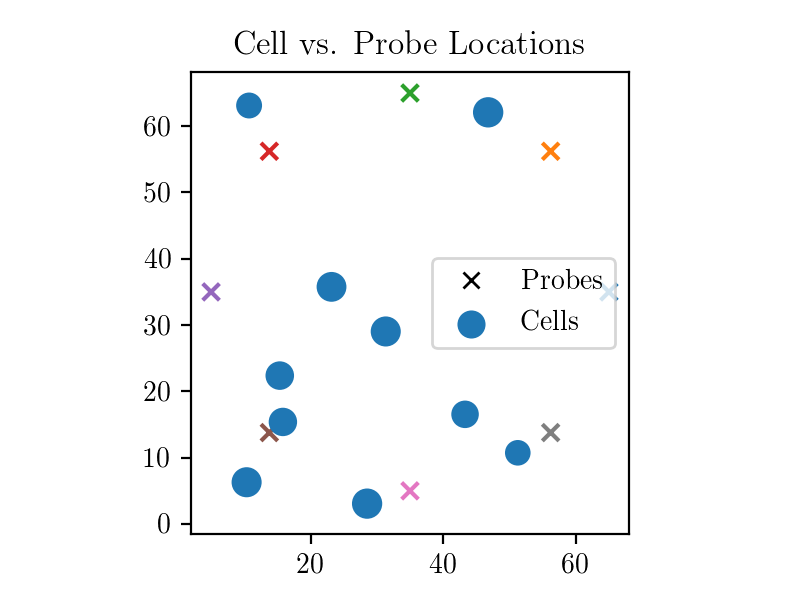

In [23]:
plt.figure()
plt.gca(aspect='equal')
plt.plot([], [], 'kx', label='Probes')
plt.scatter(points[0,:], points[1,:], marker='x', 
            color=[f'C{i}' for i in range(n_probes)])
plt.scatter(XY[0,:], XY[1,:], s=C, label='Cells')
plt.title('Cell vs. Probe Locations')
plt.legend()

In [25]:
# Use a butterworth filter because brickwall filters 
# are unnecessarily expensive in this application.
def butter_highpass(cutoff, fs, order=5):
    return signal.butter(order, 2*cutoff/fs, analog=False,
                         btype='high', output='sos')
sos = butter_highpass(100, fs=1000, order=3)
statesf = signal.sosfilt(sos, states_pde.T).T

<IPython.core.display.Javascript object>


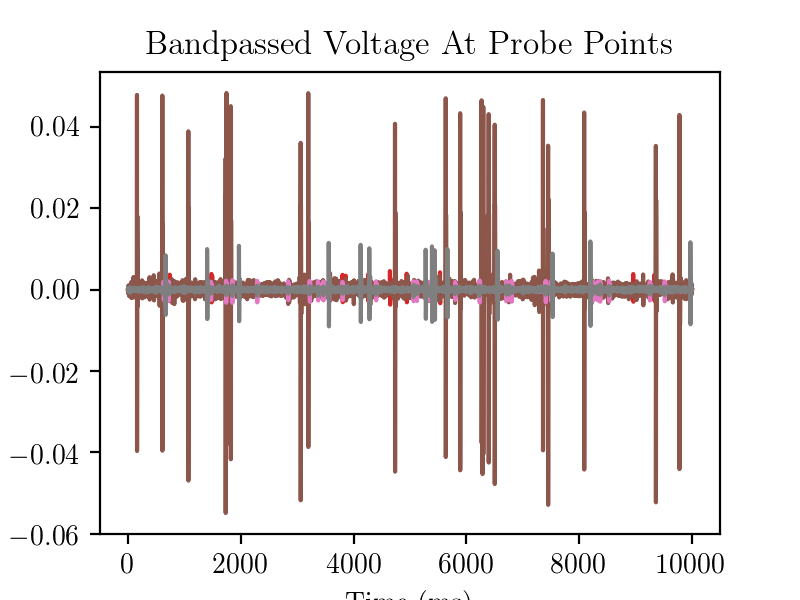

In [26]:
plt.figure(figsize=(4,3))
plt.plot(range(tmax), statesf)
plt.title('Bandpassed Voltage At Probe Points')
plt.xlabel('Time (ms)')
plt.ylabel('Probe Voltage (mV)')
None

In [29]:
np.save('probe_data_100Hz_highpass.npy', statesf)